In [1]:
# Import libraries and set desired options
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
PATH_TO_DATA = Path("../../_static/data/assignment4")

In [3]:
# Read the training and test data sets, change paths if needed
times = ["time%s" % i for i in range(1, 11)]
# customize the paths if needed
train_df = pd.read_csv(
    PATH_TO_DATA / "train_sessions.csv.zip", index_col="session_id", parse_dates=times
)
test_df = pd.read_csv(
    PATH_TO_DATA / "test_sessions.csv.zip", index_col="session_id", parse_dates=times
)

# Sort the data by time
train_df = train_df.sort_values(by="time1")

# Look at the first rows of the training set
train_df.head(2)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0


In [4]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ["site%s" % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(PATH_TO_DATA / "site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(
    list(site_dict.keys()), index=list(site_dict.values()), columns=["site"]
)
print(u"Websites total:", sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [5]:
# Top websites in the training data set
top_sites = (
    pd.Series(train_df[sites].values.flatten())
    .value_counts()
    .sort_values(ascending=False)
    .head(5)
)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com


In [6]:
# Alice's preferences
top_sites_alice = (
    pd.Series(train_df[train_df.target == 1][sites].values.flatten())
    .value_counts()
    .sort_values(ascending=False)
    .head()
)
print(top_sites_alice)
sites_dict.loc[top_sites_alice.index]
# First three -- youtube

77    1382
80    1354
76    1307
29     897
21     857
dtype: int64


,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr


In [7]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df["target"] = train_df["target"]

# Find sessions' starting and ending
time_df["min"] = train_df[times].min(axis=1)
time_df["max"] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df["seconds"] = (time_df["max"] - time_df["min"]) / np.timedelta64(1, "s")

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In [8]:
# Answers (look at the table)
# Statement 1: Check mean values in the table 52.29 < 139.28, hence this statement is true.

# Statement 2: 0.00905 less than 0.01, hence this statement is wrong.
print(u"Alice's sessions share: {}".format(2297 / (251264 + 2297)))

# Statement 3: Check min and max values in the table
# [0;1800] ~= [0;1763], hence this statement is true.

# Statement 4: Check std in the table: 297 > 153, hence this statement is wrong.

# Statement 5: For Alice's sessions q75% = 38 which is less than 40, hence this statement is true.

time_df.groupby(["target"])[["seconds"]].describe()

Alice's sessions share: 0.00905896411514389


seconds                                                       
           count        mean         std  min  25%   50%    75%     max
target                                                                 
0       251264.0  139.282372  296.653518  0.0  7.0  28.0  114.0  1800.0
1         2297.0   52.296474  153.309014  0.0  4.0  11.0   38.0  1763.0

In [9]:
# Our target variable
y_train = train_df["target"]

# United dataframe of the initial data
full_df = pd.concat([train_df.drop("target", axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [10]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [11]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(
    (
        [1] * sites_flatten.shape[0],
        sites_flatten,
        range(0, sites_flatten.shape[0] + 10, 10),
    )
)[:, 1:]

In [12]:
full_sites_sparse.shape

(336358, 48371)

In [13]:
# How much memory does a sparse matrix occupy?
print(
    "{} elements * {} bytes = {} bytes".format(
        full_sites_sparse.count_nonzero(), 8, full_sites_sparse.count_nonzero() * 8
    )
)
# Or just like this:
print("sparse_matrix_size = {} bytes".format(full_sites_sparse.data.nbytes))

1866898 elements * 8 bytes = 14935184 bytes
sparse_matrix_size = 14935184 bytes


In [14]:
# data, create the list of ones, length of which equal to the number of elements in the initial dataframe (9)
# By summing the number of ones in the cell, we get the frequency,
# number of visits to a particular site per session
data = [1] * 9

# To do this, you need to correctly distribute the ones in cells
# Indices - website ids, i.e. columns of a new matrix. We will sum ones up grouping them by sessions (ids)
indices = [1, 0, 0, 1, 3, 1, 2, 3, 4]

# Indices for the division into rows (sessions)
# For example, line 0 is the elements between the indices [0; 3) - the rightmost value is not included
# Line 1 is the elements between the indices [3; 6)
# Line 2 is the elements between the indices [6; 9)
indptr = [0, 3, 6, 9]

# Aggregate these three variables into a tuple and compose a matrix
# To display this matrix on the screen transform it into the usual "dense" matrix
csr_matrix((data, indices, indptr)).todense()

matrix([[2, 1, 0, 0, 0],
        [0, 2, 0, 1, 0],
        [0, 0, 1, 1, 1]])

In [15]:
# Answer
# After you remove zero column from matrix there will be 6 zero elements and 6 non-zero elements --> 50%
m_sp = csr_matrix((data, indices, indptr))[:, 1:]
print("{}%".format(m_sp.count_nonzero() / (m_sp.shape[0] * m_sp.shape[1]) * 100))

50.0%


In [16]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio=0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver="liblinear").fit(
        X[:idx, :], y[:idx]
    )
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)

    return score

In [17]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9195230491186374
CPU times: user 15 s, sys: 3.41 s, total: 18.4 s
Wall time: 3.27 s


In [18]:
# Function for writing predictions to a file
def write_to_submission_file(
    predicted_labels, out_file, target="target", index_label="session_id"
):
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(1, predicted_labels.shape[0] + 1),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

In [19]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17, solver="liblinear").fit(
    X_train, y_train
)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:, :]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, "baseline_1.csv")

In [20]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat["start_month"] = (
    full_df["time1"].apply(lambda ts: 100 * ts.year + ts.month).astype("float64")
)

start_month
201301.0      0
201302.0     61
201303.0      0
201304.0     38
201305.0      0
201306.0      0
201307.0      0
201308.0      0
201309.0    377
201310.0      0
201311.0    446
201312.0    134
201401.0    129
201402.0    410
201403.0    400
201404.0    302
Name: target, dtype: int64


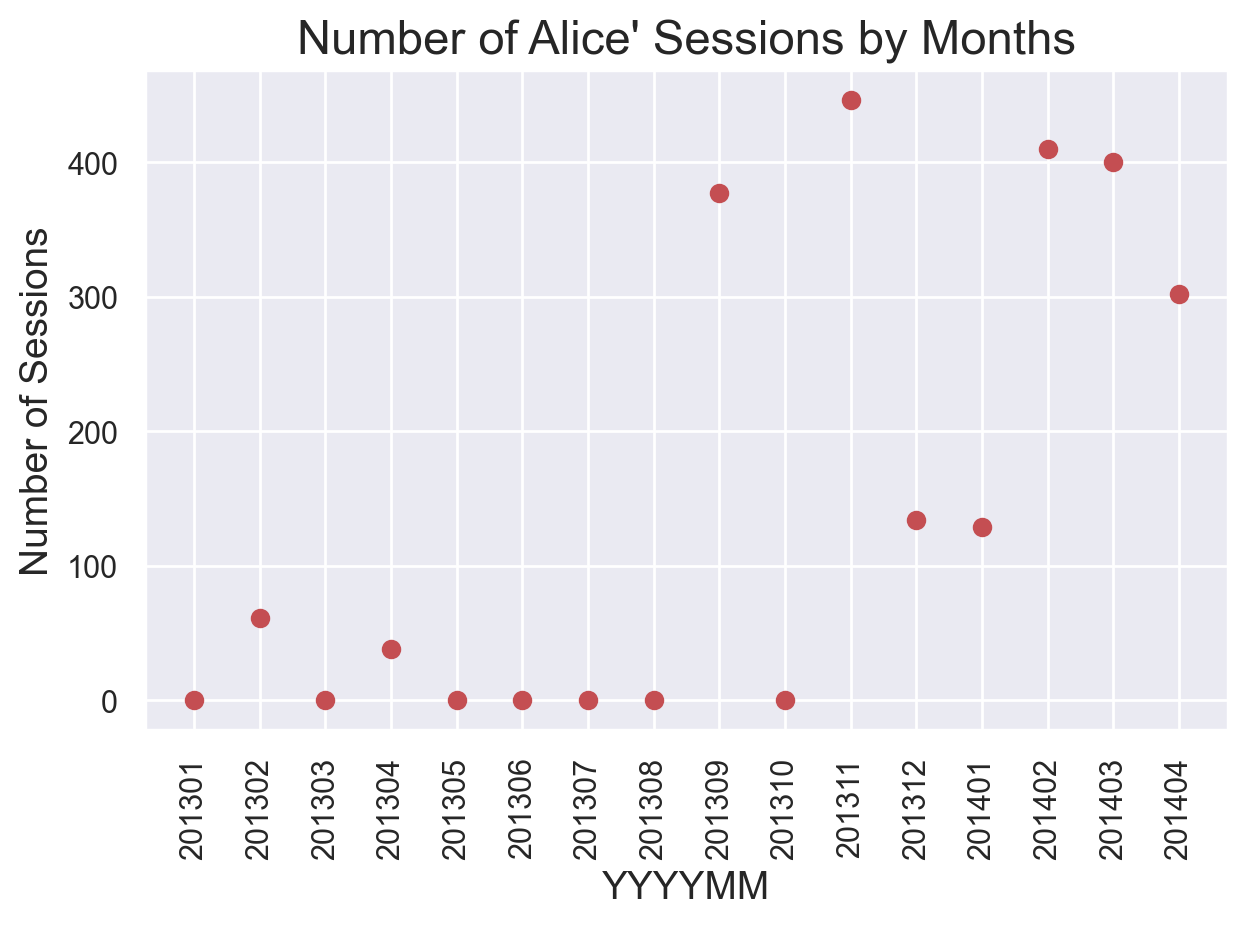

In [21]:
# Answer

# Compute number of Alice's sessions by months
tmp = full_new_feat.loc[:idx_split, "start_month"].to_frame()
tmp["target"] = y_train
stm_vs_target = tmp.groupby("start_month")["target"].sum()

# Print the table
print(stm_vs_target)

# Plot the graph
x_axis = stm_vs_target.index.astype("int").astype("str")
y_axis = stm_vs_target.values
plt.plot(x_axis, y_axis, "ro")
plt.xticks(x_axis, x_axis, rotation="vertical")
plt.xlabel("YYYYMM", fontsize=14)
plt.ylabel("Number of Sessions", fontsize=14)
plt.title(u"Number of Alice' Sessions by Months", y=1.0, fontsize=17)
plt.tight_layout();

In [22]:
# Add the new feature to the sparse matrix
tmp = full_new_feat[["start_month"]].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split, :], tmp[:idx_split, :]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.7508354860175162


In [23]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[["start_month"]])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split, :], tmp[:idx_split, :]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9196993699549294


In [24]:
# Answer
full_new_feat["n_unique_sites"] = (
    full_df[sites].apply(lambda x: x.nunique(), axis=1).astype("float64")
)

# Without n_unique_sites scaling
tmp_raw_features = full_new_feat[["n_unique_sites"]].values
tmp_scaled_scaled_features = StandardScaler().fit_transform(full_new_feat[["start_month"]])
X_train_without_n_unique_sites_scaling = csr_matrix(
    hstack(
        [
            full_sites_sparse[:idx_split, :],
            tmp_scaled_scaled_features[:idx_split, :],
            tmp_raw_features[:idx_split, :],
        ]
    )
)

# Calculate the metric on validation set
print(get_auc_lr_valid(X_train_without_n_unique_sites_scaling, y_train))


# With n_unique_sites scaling
tmp_scaled_scaled_features = StandardScaler().fit_transform(
    full_new_feat[["start_month", "n_unique_sites"]]
)
X_train_with_n_unique_sites_scaling = csr_matrix(
    hstack([full_sites_sparse[:idx_split, :], tmp_scaled_scaled_features[:idx_split, :]])
)

# Calculate the metric on validation set
print(get_auc_lr_valid(X_train_with_n_unique_sites_scaling, y_train))

0.9163648983860605


0.9156855800955513


In [25]:
# Answer
full_new_feat["start_hour"] = (
    full_df["time1"].apply(lambda ts: ts.hour).astype("float64")
)
full_new_feat["morning"] = full_new_feat["start_hour"].apply(
    lambda hour: float(hour <= 11)
)

# Scaled start_hour feature
tmp_scaled_features = StandardScaler().fit_transform(
    full_new_feat[["start_month", "start_hour"]]
)
X_train = csr_matrix(
    hstack([full_sites_sparse[:idx_split, :], tmp_scaled_features[:idx_split, :]])
)
print("Scaled start_hour feature, AUC: %f" % get_auc_lr_valid(X_train, y_train))

# Raw start_hour feature
tmp_raw_features = full_new_feat[["start_hour"]].values
tmp_scaled_features = StandardScaler().fit_transform(full_new_feat[["start_month"]])
X_train = csr_matrix(
    hstack(
        [
            full_sites_sparse[:idx_split, :],
            tmp_scaled_features[:idx_split, :],
            tmp_raw_features[:idx_split, :],
        ]
    )
)
print("Raw start_hour feature, AUC: %f" % get_auc_lr_valid(X_train, y_train))

# Scaled morning feature
tmp_scaled_features = StandardScaler().fit_transform(full_new_feat[["start_month", "morning"]])
X_train = csr_matrix(
    hstack([full_sites_sparse[:idx_split, :], tmp_scaled_features[:idx_split, :]])
)
print("Scaled morning feature, AUC: %f" % get_auc_lr_valid(X_train, y_train))

# Raw morning feature
tmp_raw_features = full_new_feat[["morning"]].values
tmp_scaled_features = StandardScaler().fit_transform(full_new_feat[["start_month"]])
X_train = csr_matrix(
    hstack(
        [
            full_sites_sparse[:idx_split, :],
            tmp_scaled_features[:idx_split, :],
            tmp_raw_features[:idx_split, :],
        ]
    )
)
print("Raw morning feature, AUC: %f" % get_auc_lr_valid(X_train, y_train))

# Scaled start_hour and morning features
tmp_scaled_features = StandardScaler().fit_transform(
    full_new_feat[["start_month", "start_hour", "morning"]]
)
X_train = csr_matrix(
    hstack([full_sites_sparse[:idx_split, :], tmp_scaled_features[:idx_split, :]])
)
print(
    "Scaled start_hour and morning features, AUC: %f"
    % get_auc_lr_valid(X_train, y_train)
)

Scaled start_hour feature, AUC: 0.957925


Raw start_hour feature, AUC: 0.957290


Scaled morning feature, AUC: 0.948777


Raw morning feature, AUC: 0.948667


Scaled start_hour and morning features, AUC: 0.959150


In [26]:
# Compose the training set
tmp_scaled_features = StandardScaler().fit_transform(
    full_new_feat[["start_month", "start_hour", "morning"]]
)
X_train = csr_matrix(
    hstack([full_sites_sparse[:idx_split, :], tmp_scaled_features[:idx_split, :]])
)

# Capture the quality with default parameters
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

0.9591499493983353


In [27]:
from tqdm import tqdm

# List of possible C-values
Cs = np.logspace(-3, 1, 10)
scores = []
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

  0%|                                                                                                                               | 0/10 [00:00<?, ?it/s]

 10%|███████████▉                                                                                                           | 1/10 [00:00<00:04,  1.85it/s]

 20%|███████████████████████▊                                                                                               | 2/10 [00:01<00:04,  1.64it/s]

 30%|███████████████████████████████████▋                                                                                   | 3/10 [00:01<00:04,  1.45it/s]

 40%|███████████████████████████████████████████████▌                                                                       | 4/10 [00:03<00:05,  1.19it/s]

 50%|███████████████████████████████████████████████████████████▌                                                           | 5/10 [00:04<00:05,  1.04s/it]

 60%|███████████████████████████████████████████████████████████████████████▍                                               | 6/10 [00:06<00:05,  1.34s/it]

 70%|███████████████████████████████████████████████████████████████████████████████████▎                                   | 7/10 [00:09<00:05,  1.76s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8/10 [00:12<00:04,  2.17s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9/10 [00:17<00:03,  3.22s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  5.67s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.87s/it]

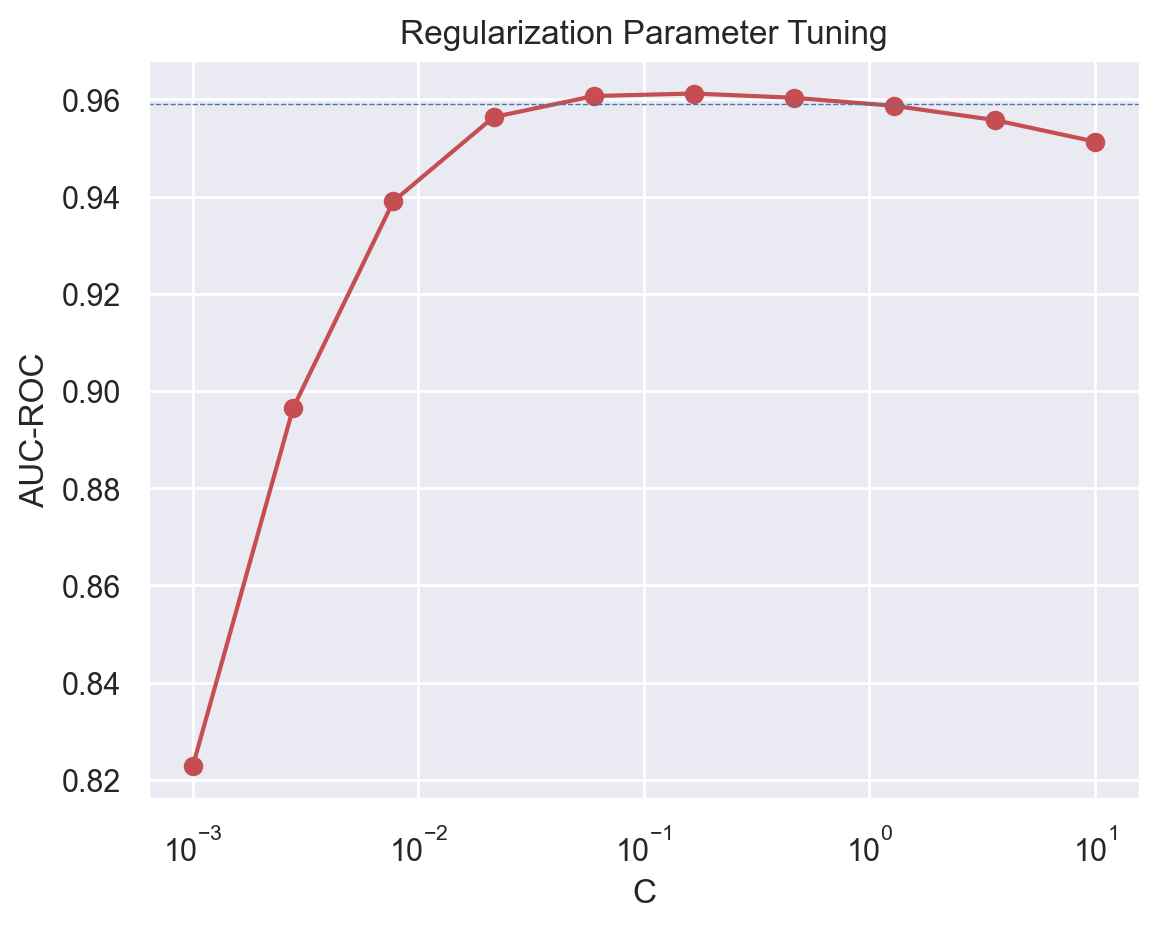

In [28]:
plt.plot(Cs, scores, "ro-")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("AUC-ROC")
plt.title("Regularization Parameter Tuning")
# horizontal line -- model quality with default C value
plt.axhline(y=score_C_1, linewidth=0.5, color="b", linestyle="dashed")
plt.show()

In [29]:
# Answer
C = Cs[scores.index(max(scores))]
print(C)

0.1668100537200059


In [30]:
# Prepare the training and test data
tmp_scaled_features = StandardScaler().fit_transform(
    full_new_feat[["start_month", "start_hour", "morning"]]
)
X_train = csr_matrix(
    hstack([full_sites_sparse[:idx_split, :], tmp_scaled_features[:idx_split, :]])
)
X_test = csr_matrix(
    hstack([full_sites_sparse[idx_split:, :], tmp_scaled_features[idx_split:, :]])
)

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C, random_state=17, solver="liblinear").fit(X_train, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, "baseline_2.csv")